In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [15]:
# Initialize DataFrame
column_names = ['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'class']

data = pd.read_csv('./thyroid+disease/thyroid0387.data', names=column_names)

# Preprocessing

In [16]:
data.drop(columns=['referral source', 'TBG', 'TBG measured', 'T3 measured', 'TSH measured', 'TT4 measured', 'T4U measured', 'FTI measured'], inplace=True)
data.drop([8105, 6392, 5710, 2976], inplace=True)                              # Drop age outliers
data.replace('?', np.nan, inplace=True)                                        # Format missing values with NaN (np.nan)
for index in data.index.values:
    data.at[index, 'class'] = data['class'][index][:data['class'][index].index('[')]    # Format class variables
    if len(data.at[index, 'class']) > 1:
        data.at[index, 'class'] = data['class'][index][-1]              # Simplify multiple classifications by replacing with rightmost classification
data['sex'].replace({'M':0,'F':1}, inplace=True)                        # Binary encoding of sex attribute
boolean_columns = ['on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']
for column_name in boolean_columns:
    data[column_name].replace({'f': 0, 't': 1}, inplace=True)           # Binary encoding of boolean attributes

data

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,class
0,29,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0.3,NaN,NaN,NaN,NaN,-
1,29,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.6,1.9,128,NaN,NaN,-
2,41,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,-
3,36,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,-
4,32,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,64,0.83,77,-
9168,22,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,91,0.92,99,-
9169,69,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,113,1.27,89,I
9170,47,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,75,0.85,88,-


Text(0, 0.5, 'Age')

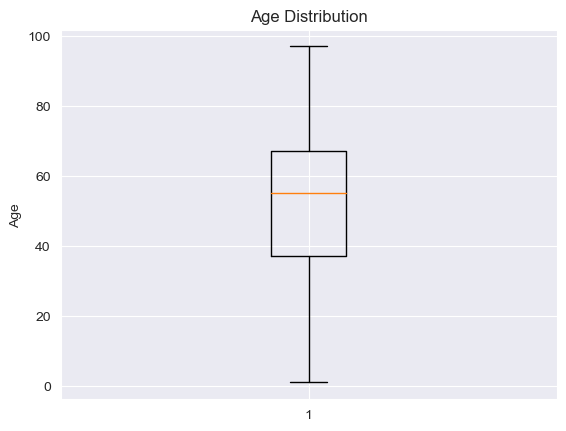

In [17]:
# TEMP Age Boxplot
plt.boxplot(data['age'])
plt.title('Age Distribution')
plt.ylabel('Age')

In [4]:
# Display Missing Values
print('--TOTAL_MISSING--: ', data.isna().sum().sum())
data.isna().sum().loc[lambda x : x != 0]

--TOTAL_MISSING--:  5805


sex     307
TSH     842
T3     2603
TT4     442
T4U     809
FTI     802
dtype: int64

In [5]:
# Class grouping
'''
POTENTIAL CLASSES:
'-' (normal): 6767
'K' (concurrent non-thyroidal illness): 436
'G' (compensated hypothyroid): 359
'I' (increased binding protein): 346
'F' (primary hypothyroid): 233
--TOTAL--: 8141
'''
op1_classes = ['-', 'K', 'G', 'I', 'F']
op1_names = ['normal', 'concurrent non-thyroidal illness', 'compensated hypothyroid', 'increased binding protein', 'primary hypothyroid']

'''
POTENTIAL CLASSES (2):
'-' (normal): 6767
'A', 'B', 'C', 'D' (hyperthyroidism): 182
'E', 'F', 'G', 'H' (hypothyroidism): 593
'I', 'J' (abnormal-binding-protein): 376
'K' (non-thyroidal-sick): 436
'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T' (other): 651
--TOTAL--: 9168
'''
original_classes = [['-'], ['K'], ['A', 'B', 'C', 'D'], ['E', 'F', 'G', 'H'], ['I', 'J'], ['L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']]
new_classes = ['normal', 'non-thyroidal-sick', 'hyperthyroidism', 'hypothyroidism', 'abnormal-binding-protein', 'other']

# Ungrouped (letter classes) class counter
# sum_instances = 0
# for char_list in op2_classes:
#     curr_sum = 0
#     for char_index in char_list:
#         curr_sum += len(data.loc[data['class'] == char_index])
#     print(str(op2_names[op2_classes.index(char_list)]) + ':', curr_sum)
#     sum_instances += curr_sum
# print('--TOTAL--:', sum_instances)

# Group and relabel data
for i in range(len(new_classes)):
    data = data.replace(original_classes[i], new_classes[i])


# Grouped Class counter
total_instances = 0
for class_name in data['class'].unique():
    print(class_name + ':', len(data.loc[data['class'] == class_name]))
    total_instances += len(data.loc[data['class'] == class_name])
print('--TOTAL--:', total_instances)

normal: 6767
other: 651
hypothyroidism: 593
non-thyroidal-sick: 561
abnormal-binding-protein: 414
hyperthyroidism: 182
--TOTAL--: 9168


# Data Visualization

Text(0.5, 1.0, 'Class distribution')

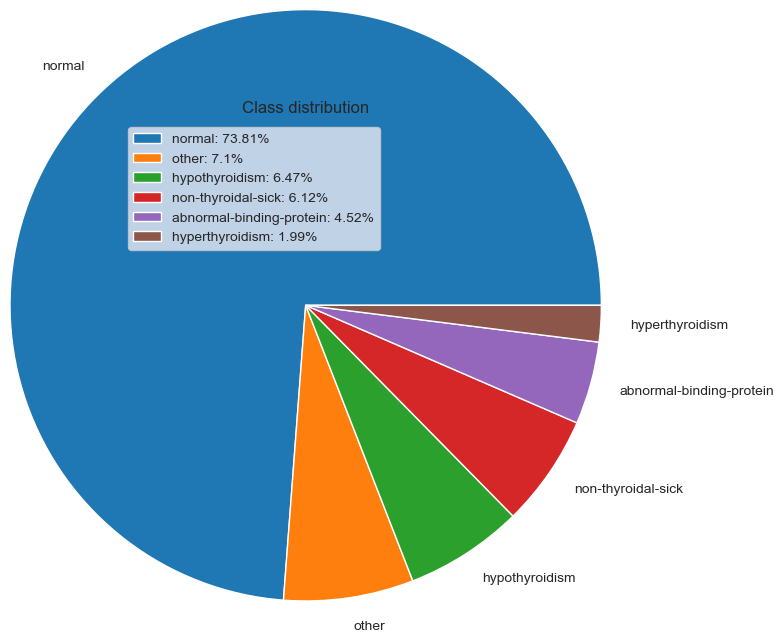

In [167]:
# Class distribution pie chart
class_distribution = {}
for class_name in data['class'].unique():
    class_distribution[class_name] = (len(data[data['class'] == class_name]) / len(data) * 100).__round__(2)

class_distribution = dict(sorted(class_distribution.items(), key=lambda x:x[1], reverse=True))

labels = list(class_distribution.keys())
sizes = list(class_distribution.values())

legend_labels = [f'{class_name}: {percentage}%' for class_name, percentage in class_distribution.items()]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, radius=2)
plt.legend(loc='upper left', labels=legend_labels)
plt.title('Class distribution')

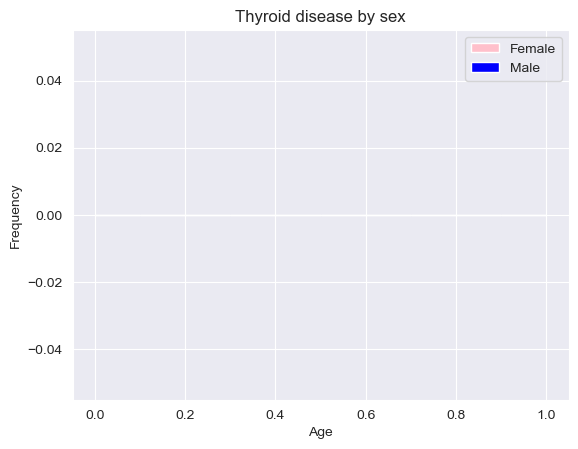

In [297]:
# Frequency of thyroid-related disease by age and grouped by sex
M = data.loc[(data['sex'] == '1') & (data['class'] != 'other'), 'age']
F = data.loc[(data['sex'] == '2') & (data['class'] != 'other'), 'age']

plt.hist(F, alpha=1, label='Female', color='Pink')
plt.hist(M, alpha=1, label='Male', color='blue')

plt.title('Thyroid disease by sex')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

Text(0, 0.5, 'class')

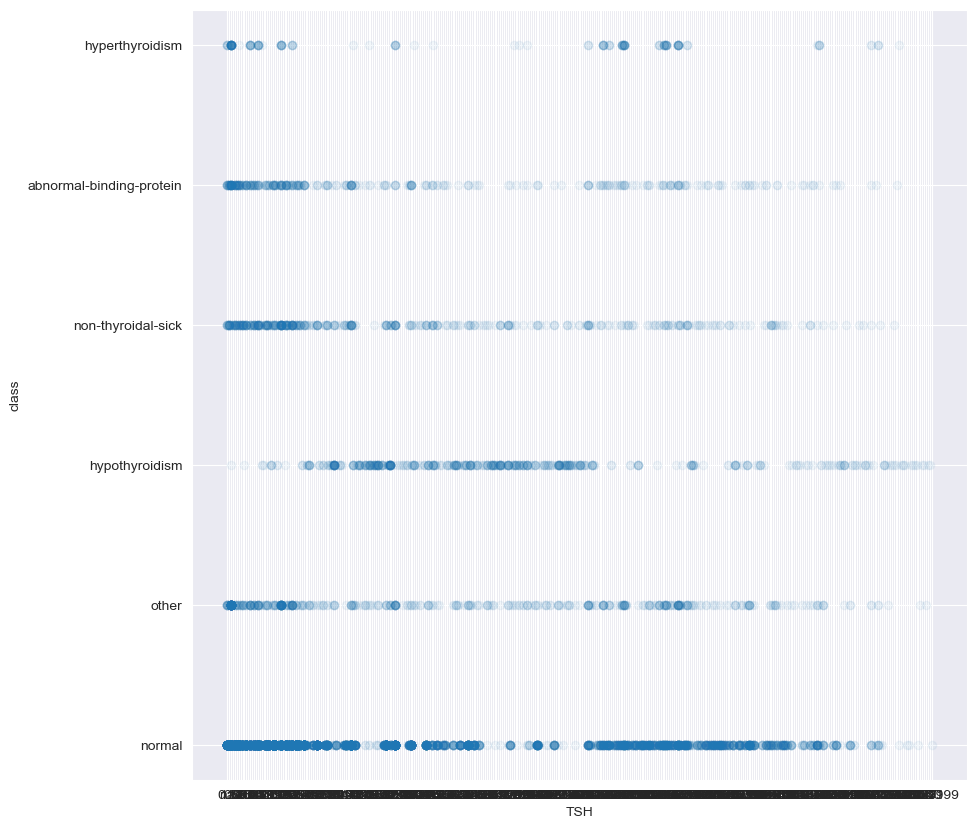

In [298]:
plt.figure(figsize= (10, 10))
plt.scatter(data['TSH'].astype(str, errors='ignore'), data['class'].astype(str, errors='ignore'), alpha=0.05)
plt.xlabel('TSH')
plt.ylabel('class')

([<matplotlib.axis.YTick at 0x22f00fcc1f0>,
 [Text(0, 0.0, '0'),
  Text(0, 60.0, '60'),
  Text(0, 120.0, '120'),
  Text(0, 180.0, '180'),
  Text(0, 240.0, '240'),
  Text(0, 300.0, '300')])

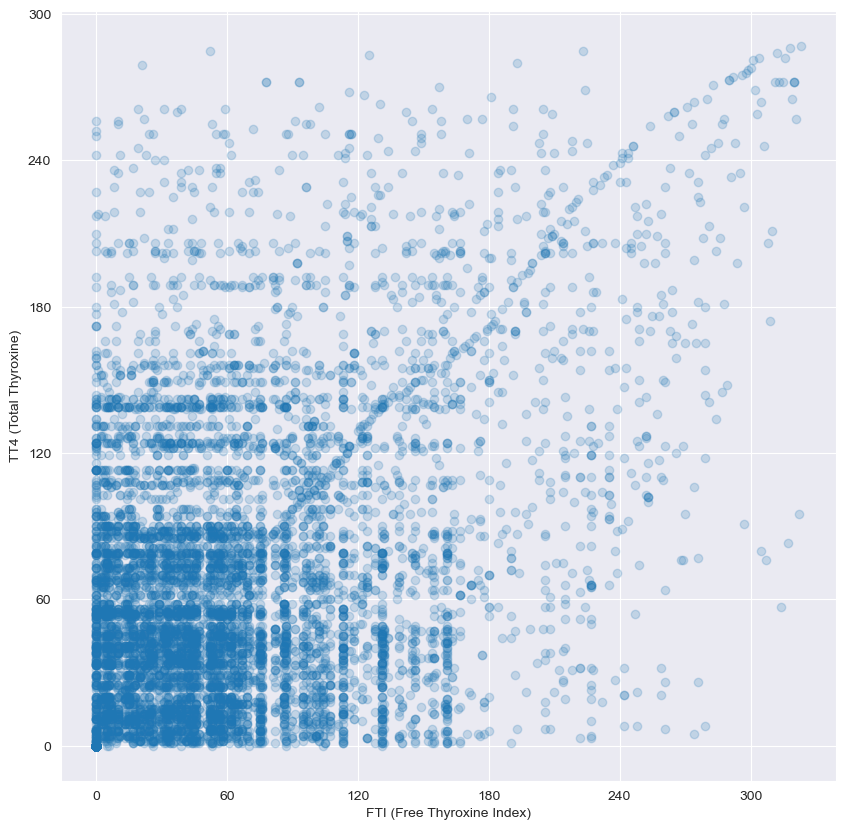

In [299]:
# Scatterplot
plt.figure(figsize= (10, 10))
plt.scatter(data['FTI'].astype(str, errors='ignore'), data['TT4'].astype(str, errors='ignore'), alpha=0.2)
plt.xlabel('FTI (Free Thyroxine Index)')
plt.ylabel('TT4 (Total Thyroxine)')
plt.xticks(np.linspace(0, 300, 6), np.linspace(0, 300, 6).astype(int))
plt.yticks(np.linspace(0, 300, 6), np.linspace(0, 300, 6).astype(int))

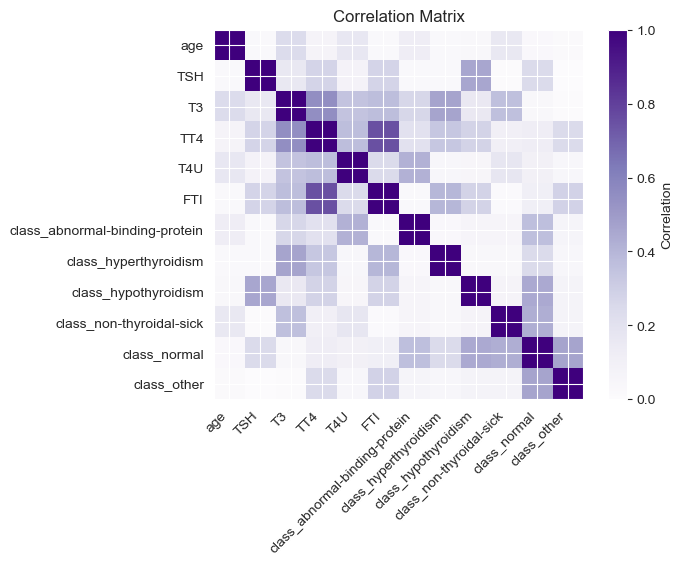

In [300]:
# Continuous data correlation matrix

continuous_attributes = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'class']
continuous_data = pd.DataFrame(columns=continuous_attributes)


for attribute_name in continuous_attributes:
    continuous_data[attribute_name] = data[attribute_name].astype(float, errors='ignore')

continuous_data = pd.get_dummies(continuous_data, columns=['class'], prefix=['class'])

# Calculate the correlation matrix
correlation_matrix = continuous_data.corr(method='pearson')

# Create a figure and axis
fig, ax = plt.subplots()

# Create a heatmap of the correlation matrix
heatmap = ax.imshow(abs(correlation_matrix), cmap='Purples', vmin=0, vmax=1) # We use abs to make all the values positive. This is why we use a range from 0 to 1

# Add colorbar
cbar = fig.colorbar(heatmap)
cbar.set_label('Correlation')

# Set tick labels and tick positions
ax.set_xticks(np.arange(len(continuous_data.columns))) # + 1 because there is a target variable added
ax.set_yticks(np.arange(len(continuous_data.columns)))
ax.set_xticklabels(continuous_data.columns, rotation=45, ha='right')
ax.set_yticklabels(continuous_data.columns)

# Add title and show the plot
ax.set_title('Correlation Matrix')
plt.show()

C:\Users\Akash\AppData\Local\Temp\ipykernel_51692\407320438.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method='pearson'), annot=True, cmap='Purples')


<Axes: >

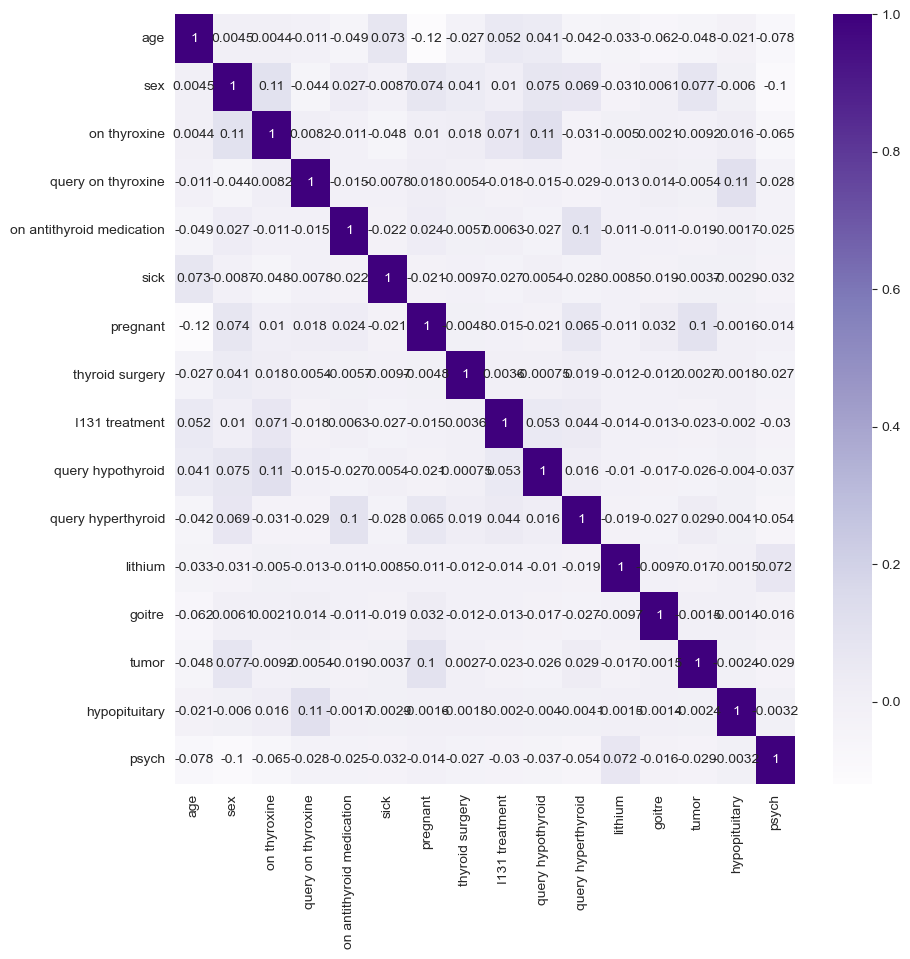

In [301]:
# Correlation Matrix between attributes with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(method='pearson'), annot=True, cmap='Purples')

# Model Training

## Preprocessing

In [6]:
# Drop all instances with missing values
data.dropna(inplace=True)
# Resolve class imbalance of 'normal' through sampling
data.drop(data.loc[data['class'] == 'normal'].sample((len(data.loc[data['class'] == 'normal']) - 900), random_state=1).index, inplace=True)
# OneHotEncoding with Pandas
data = pd.get_dummies(data, columns=['class'], prefix=['class'])

In [7]:
exploded_class_names = ['class_abnormal-binding-protein', 'class_hyperthyroidism', 'class_hypothyroidism', 'class_non-thyroidal-sick', 'class_normal', 'class_other']

X = data.drop(columns=exploded_class_names)
y = data[exploded_class_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, train_size=0.8, stratify=y)

## kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### PREPROCESSING ###
# Standardize scale
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

knn = KNeighborsClassifier(metric='euclidean', weights='distance', algorithm='kd_tree')
# knn = GridSearchCV(knn, {'n_neighbors': np.arange(1, 10)}, cv=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

# Performance Metrics
print(metrics.classification_report(y_test, knn_pred))
# print(knn.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.64      0.74        50
           1       0.86      0.83      0.84        23
           2       0.88      0.49      0.63        75
           3       0.72      0.66      0.69       104
           4       0.68      0.74      0.71       180
           5       0.65      0.56      0.60        73

   micro avg       0.73      0.66      0.69       505
   macro avg       0.78      0.65      0.70       505
weighted avg       0.74      0.66      0.69       505
 samples avg       0.66      0.66      0.66       505



C:\Users\Akash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
# dt = GridSearchCV(dt, {'max_depth': np.arange(5, 30), 'max_features': np.arange(10, 100, 10)}, cv=5)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, dt_pred))
# print(dt.best_params_)

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        50
           1       0.80      0.87      0.83        23
           2       0.99      1.00      0.99        75
           3       0.94      0.98      0.96       104
           4       0.99      0.93      0.96       180
           5       0.95      0.95      0.95        73

   micro avg       0.95      0.95      0.95       505
   macro avg       0.92      0.94      0.93       505
weighted avg       0.95      0.95      0.95       505
 samples avg       0.95      0.95      0.95       505



## Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=48, max_features=17, random_state=0)
# rf = GridSearchCV(rf, {'max_features': np.arange(10, 100, 10), 'n_estimators': np.arange(10, 100, 10)}, cv=5)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, rf_pred))
# print(rf.best_params_)

0.9706149374937109
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.84      0.91      0.87        23
           2       0.99      1.00      0.99        75
           3       0.94      0.99      0.96       104
           4       0.99      0.92      0.96       180
           5       0.97      0.90      0.94        73

   micro avg       0.96      0.95      0.96       505
   macro avg       0.94      0.95      0.95       505
weighted avg       0.97      0.95      0.96       505
 samples avg       0.95      0.95      0.95       505



C:\Users\Akash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gradient Tree Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier

gb = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=350, max_features=20, random_state=1))
gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

# Performance Metrics
print(metrics.classification_report(y_test, gb_pred))

0.9577552038953415
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        50
           1       0.88      0.91      0.89        23
           2       0.95      1.00      0.97        75
           3       0.92      0.97      0.94       104
           4       0.97      0.92      0.95       180
           5       0.97      0.84      0.90        73

   micro avg       0.94      0.93      0.94       505
   macro avg       0.93      0.93      0.93       505
weighted avg       0.95      0.93      0.94       505
 samples avg       0.92      0.93      0.93       505



C:\Users\Akash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Classification Performance Visualizations

In [251]:
# Cross Validation
from sklearn.model_selection import cross_val_score

model = gb

cv_roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('Cross Validation Results (ROC AUC):')
for i, score in enumerate(cv_roc_auc):
    print(str(i + 1) + ":", score)
print('Average score (ROC AUC):', round(np.average(cv_roc_auc), ndigits=3))
print()
cv_f1 = cross_val_score(model, X, y, cv=5, scoring='f1_samples')
print('Cross Validation Results (f1):')
for i, score in enumerate(cv_f1):
    print(str(i) + ":", score)
print('Average score (f1):', round(np.average(cv_f1), ndigits=3))

Cross Validation Results (ROC AUC):
1: 0.9912562129228868
2: 0.9913115905129302
3: 0.993536334361716
4: 0.9848861741290887
5: 0.9846622398983259
Average score (ROC AUC): 0.989

Cross Validation Results (f1):
0: 0.9306930693069307
1: 0.8971560846560845
2: 0.9437830687830687
3: 0.9074074074074073
4: 0.8935185185185185
Average score (f1): 0.915


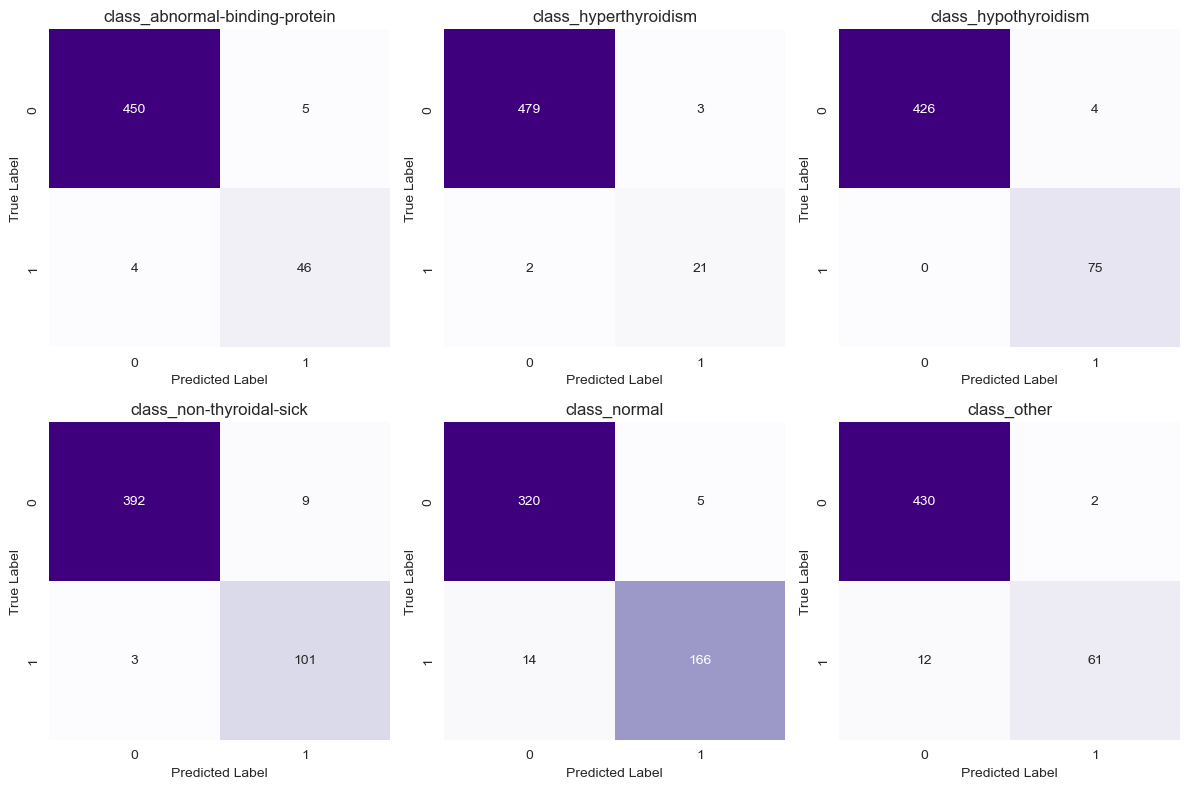

In [252]:
# Confusion matrices
y_pred = gb_pred
# Get the multi-label confusion matrices
confusion_matrices = metrics.multilabel_confusion_matrix(y_test, y_pred)

# Plot each confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
for i, cm in enumerate(confusion_matrices):
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(exploded_class_names[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'ROC AUC Score')

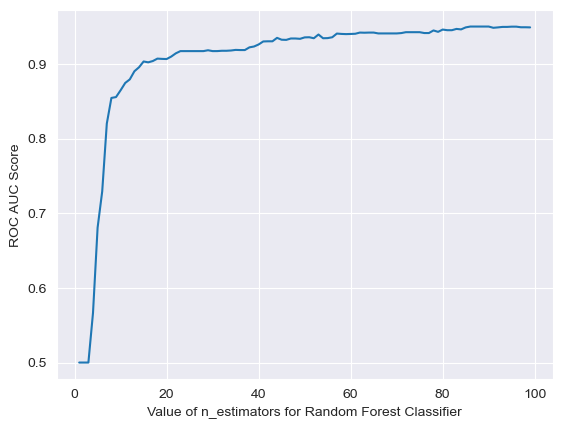

In [25]:
# Random Forest finding number of trees
scores = []
for k in range(1, 100):
    rfc = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=k, random_state=0))
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores.append(metrics.roc_auc_score(y_test, y_pred))

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('ROC AUC Score')

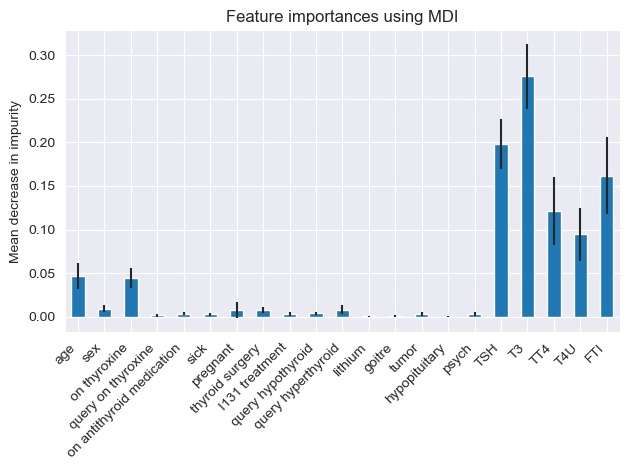

In [90]:
# Feature Importance
feature_names = ['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45, ha='right')
fig.tight_layout()